# South Cascade CSM stereo run
- Shashank Bhushan and Seth Vanderwilt
- May-June 2023

- Demonstration of the workflow to create a stack of inputs for elevation refinement models- this notebook shows execution with South Cascade 2019 stereo pair based on previous iterations on this dataset.
- Next steps:
  * Remove remaining hardcoding of filenames / ASP outputs / CRS
  * Set reasonable bounds based on stereo pair & lidar intersection
  * Pull these revised commands back into generic stereo script rather than having to execute in notebook
  * (In script) final steps of copying stack of desired rasters into single folder

## Define variables

In [1]:
pair_dir = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600"
# WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.ntf

### TODO: Determine common intersection extent
* Better way: extract URLON ULLAT etc. fields from the XML and find the shared bbox between the images and lidar point cloud to use for rest of dataset creation.

In [2]:
xmin, ymin, xmax, ymax = (639750, 5350750, 648750, 5359750)  # bounds in reprojected CRS


In [3]:
lidar_reference_bareground_laz = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/20190506_SOUTH_CASCADE_DATASET/merged_tiles_deduplicated.laz"

## Find the left and right images based on XML metadata

In [13]:
%ls $pair_dir

104001004C8CF300.r100.xml
104001004CBC0600.r100.xml
WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.ntf
WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.xml
WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.ntf
WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.tif
WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.xml


In [4]:
import os
import xml.etree.ElementTree as ET
import glob
import rioxarray

In [8]:
xml_pattern = os.path.join(pair_dir, "*r100.xml")
image_gsds = []
for xml_fn in glob.glob(xml_pattern):
    root = ET.parse(xml_fn)
    # Extract mean GSD from the metadata fields
    meanGSD = round(float(root.find("./IMD/IMAGE/MEANPRODUCTGSD").text),3)

    print(os.path.basename(xml_fn), meanGSD)
    image_id = os.path.basename(xml_fn).split(".")[0]
    
    # Extract fields of interest and just keep all metadata around as 'xml_root'
    image_dict = {
        "xml_fn": xml_fn,
        "image_fn": xml_fn.replace("xml", "tif"),
        "meanGSD": meanGSD,
        "image_id": image_id,
        "xml_root": root
    }
    
    image_gsds.append(image_dict)
    print(image_id)

left_dict = min(image_gsds, key=lambda i: i["meanGSD"])
right_dict = max(image_gsds, key=lambda i: i["meanGSD"])
res = min(image_gsds, key=lambda i: i["meanGSD"])["meanGSD"]
print(f"Highest resolution to use for orthoimages & stereo: {res} meters")

left_image_id = left_dict["image_id"]
right_image_id = right_dict["image_id"]

left_image_fn = left_dict["image_fn"]
right_image_fn = right_dict["image_fn"]
print(f"Image ids {left_image_id} {right_image_id}")
print(f"Image fns {left_image_fn} {right_image_fn}")

104001004CBC0600.r100.xml 0.386
104001004CBC0600
104001004C8CF300.r100.xml 0.391
104001004C8CF300
Highest resolution to use for orthoimages & stereo: 0.386 meters
Image ids 104001004CBC0600 104001004C8CF300
Image fns /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/104001004CBC0600.r100.tif /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/104001004C8CF300.r100.tif


### Create TIFFs if they don't already exist
* Special case for South Cascade .ntf files, fill in or remove if needed

In [14]:
!ls $pair_dir

104001004C8CF300.r100.xml
104001004CBC0600.r100.xml
WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.ntf
WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.xml
WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.ntf
WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.tif
WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.xml


In [30]:
# !gdal_translate -ot UInt16 -co NBITS=16 -co bigtiff=if_safer -co tiled=yes -co compress=lzw $pair_dir/WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.ntf $pair_dir/WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.tif
# !gdal_translate -ot UInt16 -co NBITS=16 -co bigtiff=if_safer -co tiled=yes -co compress=lzw $pair_dir/WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.ntf $pair_dir/WV03_20190505191051_104001004C8CF300_19MAY05191051-P1BS-503126480010_01_P001.tif
for ntf_fn in glob.glob(os.path.join(pair_dir, "*.ntf")):
    tif_fn = ntf_fn.replace("ntf","tif")
    # !gdal_translate -ot UInt16 -co NBITS=16 -co bigtiff=if_safer -co tiled=yes -co compress=lzw $ntf_fn $tif_fn
    

left_image_fn = f"{pair_dir}/WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.tif"
right_image_fn = f"{pair_dir}/WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.tif"

left_image_xml =  f"{pair_dir}/104001004CBC0600.r100.xml"
right_image_xml = f"{pair_dir}/104001004C8CF300.r100.xml"

In [28]:
left_image_id

'104001004CBC0600'

In [27]:
!ls $pair_dir

104001004C8CF300.r100.xml
104001004CBC0600.r100.xml
WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.ntf
WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.tif
WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.xml
WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.ntf
WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.tif
WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.xml


## Bundle adjustment

In [31]:
!bundle_adjust --ip-per-image 10000 -t dg --dg-use-csm \
    --camera-weight 0 --tri-weight 0.1 --tri-robust-threshold 0.1 \
    $left_image_fn $right_image_fn $left_image_xml $right_image_xml \
    -o dg_csm_model_refined/run

	--> Setting number of processing threads to: 4
Found 0 GCP files on the command line.
Using session: dg
Loading camera model: /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.tif /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/104001004CBC0600.r100.xml
Using the CSM model with DigitalGlobe cameras.
Will use the datum:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs

Creating output directory: "dg_csm_model_refined".
Writing log info to: dg_csm_model_refined/run-log-bundle_adjust-06-10-1923-14477.txt
Using session: dg
Loading camera model: /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-5031

## Register camera models to reference DEM
* Using Copernicus GLO-30 Digital Elevation Model from [OpenTopography](https://portal.opentopography.org/raster?opentopoID=OTSDEM.032021.4326.3)
* Coordinate System:
  - Horizontal: WGS84 [EPSG: 4326]
  - Vertical: EGM2008 [EPSG: 3855] 

In [32]:
refdem_from_opentopography = "output_COP30.tif"
refdem = "refdem_copernicus_30m_32610_wgs84.tif" # reprojected & cropped to extent

## Adjust reference DEM to desired datum.
* Call `dem_geoid` - but only in newer ASP versions with bugfix for .jp2 datum files

In [33]:
# Adjust the Copernicus 30m product to be in heights above ellipsoid instead of EGM2008 geoid
# dem_geoid bug fixed in ASP 3.2.1+
!/mnt/1.0_TB_VOLUME/sethv/dshean_tools/StereoPipeline-3.2.1-alpha-2023-05-11-x86_64-Linux/bin/dem_geoid --reverse-adjustment --geoid EGM2008 output_COP30.tif


	--> Setting number of processing threads to: 4
Writing log info to: output_COP30-log-dem_geoid-06-10-1939-25119.txt
Adjusting the DEM using the geoid: /mnt/1.0_TB_VOLUME/sethv/dshean_tools/StereoPipeline-3.2.1-alpha-2023-05-11-x86_64-Linux/share/geoids/egm2008.jp2
Writing adjusted DEM: output_COP30-adj.tif
        --> Applying DEM adjustment: [*******************************] Complete!


In [34]:
refdem_from_opentopography_ellipsoid = refdem_from_opentopography.replace(".tif", "-adj.tif")
!gdalwarp -overwrite -r cubic -t_srs "EPSG:32610" -te $xmin $ymin $xmax $ymax $refdem_from_opentopography_ellipsoid $refdem


Creating output file that is 350P x 350L.
Processing output_COP30-adj.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image output_COP30-adj.tif.
Copying nodata values from source output_COP30-adj.tif to destination refdem_copernicus_30m_32610_wgs84.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [35]:
t_srs = "EPSG:32610"  # add vertical CRS if compatible with ASP?

In [36]:
refdem_rxr = rioxarray.open_rasterio(refdem)
refdem_opentopography_rxr = rioxarray.open_rasterio(refdem_from_opentopography)
diff = refdem_rxr - refdem_opentopography_rxr.rio.reproject_match(refdem_rxr)
print(f"Refdem in EGM2008 heights minimum elevation: {refdem_opentopography_rxr.min().item()}")
print(f"Adjusted refdem minimum elevation: {refdem_rxr.min().item()}")


Refdem in EGM2008 heights minimum elevation: 74.0
Adjusted refdem minimum elevation: 754.2649536132812


**Plot the difference after vertical datum adjustment - pixel shape artifacts expected since adjusted refdem is interpolated and raw refdem is not.**

Text(0.5, 1.0, 'Mean difference after datum change (EGM2008 -> WGS84): -16.93 m')

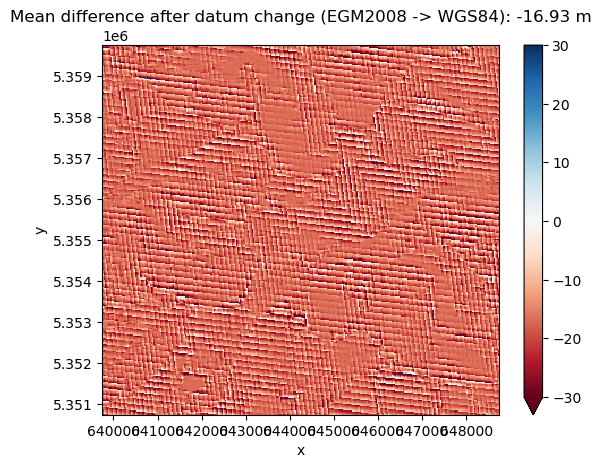

In [37]:
import matplotlib.pyplot as plt

diff.plot(vmin=-30, vmax=30, cmap="RdBu")
plt.title(f"Mean difference after datum change (EGM2008 -> WGS84): {diff.mean().item():.2f} m")


## Align sparse point cloud (which comes from initial bundle adjustment) to Copernicus DEM
* Note: this should not result in much vertical translation, but some horizontal translation

In [38]:
sparse_cloud_fn = "dg_csm_model_refined/run-final_residuals_pointmap.csv"

In [39]:
# TODO: should this alignment be translation only, or continue to allow rotation?
!pc_align --max-displacement 20 --csv-format "2:lat 1:lon 3:height_above_datum" --save-transformed-source-points $refdem $sparse_cloud_fn -o align_sparse_ba_cloud_to_cop30/align_sparse_ba_cloud_to_cop30 


	--> Setting number of processing threads to: 4

Creating output directory: "align_sparse_ba_cloud_to_cop30".
Writing log info to: align_sparse_ba_cloud_to_cop30/align_sparse_ba_cloud_to_cop30-log-pc_align-06-10-1944-29612.txt
Detected datum from refdem_copernicus_30m_32610_wgs84.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-121.116, 48.2923) width: 0.12487 height: 0.0833788)
Source box:    (Origin: (-121.173, 48.2885) width: 0.231959 height: 0.122458)
Intersection reference box:  (Origin: (-121.116, 48.2923) width: 0.12487 height: 

## Update camera models for mapproject

In [40]:
left_adjust_fn = f"dg_csm_model_refined/run-{left_image_id}.r100.adjusted_state.json"
right_adjust_fn = f"dg_csm_model_refined/run-{right_image_id}.r100.adjusted_state.json"
!bundle_adjust -t csm --apply-initial-transform-only yes $left_image_fn $right_image_fn \
    $left_adjust_fn $right_adjust_fn \
    --initial-transform align_sparse_ba_cloud_to_cop30/align_sparse_ba_cloud_to_cop30-transform.txt \
    -o csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus

	--> Setting number of processing threads to: 4
Found 0 GCP files on the command line.
Using session: csm
Loading camera model: /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.tif dg_csm_model_refined/run-104001004CBC0600.r100.adjusted_state.json
Will use the datum:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs

Creating output directory: "csm_cameras_aligned_to_copernicus".
Writing log info to: csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-log-bundle_adjust-06-10-1944-30159.txt
Reading the alignment transform from: align_sparse_ba_cloud_to_cop30/align_sparse_ba_cloud_to_cop30-transform.txt
Initial transform:
Matrix4x4((1,4.87638e-05,-0.000178986,1030.12)(-4.87777e-05,1,-7.78273e-05,278.364)(0.000178982,7.

## Orthorectification

In [ ]:
# lowres = 1.0 # meters
# left_orthoimage_lowres_fn = f"ortho_left_{lowres}.tif"
# !mapproject -t csm --ot UInt16 --t_srs $t_srs --t_projwin $xmin $ymin $xmax $ymax \
#      --tr $lowres \
#     $refdem \
#     $left_image_fn $left_adjust_fn $left_orthoimage_lowres_fn

In [41]:
left_bundle_adjusted_and_aligned_csm_fn = f"csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-{left_image_id}.r100.adjusted_state.json"
right_bundle_adjusted_and_aligned_csm_fn = f"csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-{right_image_id}.r100.adjusted_state.json"


## Mapprojection at full resolution

In [42]:
left_orthoimage_fullres_fn = f"ortho_left_{res}m.tif"
!mapproject -t csm --ot UInt16 --t_srs $t_srs \
     --t_projwin $xmin $ymin $xmax $ymax \
     --tr $res \
    $refdem \
    $left_image_fn $left_bundle_adjusted_and_aligned_csm_fn $left_orthoimage_fullres_fn

mapproject_single --query-projection refdem_copernicus_30m_32610_wgs84.tif /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.tif csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004CBC0600.r100.adjusted_state.json ortho_left_0.386m.tif -t csm --ot UInt16 --t_srs EPSG:32610 --t_projwin 639750 5350750 648750 5359750 --tr 0.386
	--> Setting number of processing threads to: 4
Using session: csm
Loading camera model: /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.tif csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004CBC0600.r100.adjusted_state.json
Output pixel size: 0.386
Projected space bounding box: (Origin: (639749.83799999999, 5350750.5279999999) width: 8999.5900000000838 height: 8999.5899999

In [43]:
right_orthoimage_fullres_fn = f"ortho_right_{res}m.tif"
!mapproject -t csm --ot UInt16 --t_srs $t_srs \
     --t_projwin $xmin $ymin $xmax $ymax \
     --tr $res \
    $refdem \
    $right_image_fn $right_bundle_adjusted_and_aligned_csm_fn $right_orthoimage_fullres_fn

mapproject_single --query-projection refdem_copernicus_30m_32610_wgs84.tif /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.tif csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004C8CF300.r100.adjusted_state.json ortho_right_0.386m.tif -t csm --ot UInt16 --t_srs EPSG:32610 --t_projwin 639750 5350750 648750 5359750 --tr 0.386
	--> Setting number of processing threads to: 4
Using session: csm
Loading camera model: /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.tif csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004C8CF300.r100.adjusted_state.json
Output pixel size: 0.386
Projected space bounding box: (Origin: (639749.83799999999, 5350750.5279999999) width: 8999.5900000000838 height: 8999.589999

## Best parallel_stereo command for run 2: same parameters, correctly reprojected and interpolated refdem
* Explanations of stereo parameters go in the README

In [46]:
x = f"""
    {left_orthoimage_fullres_fn} \\
    {right_orthoimage_fullres_fn} \\
    {left_bundle_adjusted_and_aligned_csm_fn} \\
    {right_bundle_adjusted_and_aligned_csm_fn} \\
    {stereo_run_name} \\
"""
print(x)


    ortho_left_0.386m.tif \
    ortho_right_0.386m.tif \
    csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004CBC0600.r100.adjusted_state.json \
    csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004C8CF300.r100.adjusted_state.json \
    stereo_processing/run_large_2 \



In [ ]:
# Running this actual command in Tmux
parallel_stereo \
    --corr-kernel 7 7 \
    --cost-mode 3  \
    --subpixel-kernel 15 15 \
    --subpixel-mode 9 \
    --stereo-algorithm asp_mgm \
    --alignment-method none \
    --num-matches-from-disparity 10000 \
    --corr-tile-size 1024 \
    --corr-memory-limit-mb 5000 \
    --erode-max-size 0 \
    ortho_left_0.386m.tif \
    ortho_right_0.386m.tif \
    csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004CBC0600.r100.adjusted_state.json \
    csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004C8CF300.r100.adjusted_state.json \
    stereo_processing/run_large_2 \
    refdem_copernicus_30m_32610_wgs84.tif

In [44]:
# Can transfer this long stereo process to tmux
stereo_run_name="stereo_processing/run_large_2"
!parallel_stereo \
    --corr-kernel 7 7 \
    --cost-mode 3  \
    --subpixel-kernel 15 15 \
    --subpixel-mode 9 \
    --stereo-algorithm asp_mgm \
    --alignment-method none \
    --num-matches-from-disparity 10000 \
    --corr-tile-size 1024 \
    --corr-memory-limit-mb 5000 \
    --erode-max-size 0 \
    $left_orthoimage_fullres_fn \
    $right_orthoimage_fullres_fn \
    $left_bundle_adjusted_and_aligned_csm_fn \
    $right_bundle_adjusted_and_aligned_csm_fn \
    $stereo_run_name \
    refdem_copernicus_30m_32610_wgs84.tif

Using tiles (before collar addition) of 1024 x 1024 pixels.
Using a collar (padding) for each tile of 512 pixels.

[ 2023-Jun-10 19:51:33 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 20
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log info to: stereo_processing/run_large_2-log-stereo_pprc-06-10-1951-17185.txt
Will refine the disparity using the ASP subpixel-mode: 9.
Using session: csmmapcsm
Loading camera model: ortho_left_0.386m.tif csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004CBC0600.r100.adjusted_state.json
Loading camera model: ortho_right_0.386m.tif csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004C8CF300.r100.adjusted_state.json
Distance between camera centers in meters: 376227.
Using image files:  ortho_left_0.386m.tif, ortho_right_0.386m.tif
Using camera files: csm_cameras_aligned_to_copernicus/csm_cameras_align

## DEM quality check before coregistration: create DEMs at different grid sizes

In [57]:
!echo $stereo_run_name

stereo_processing/run_large_2


In [59]:
# Can also try 2 or 3 meter grid and resample for smoother results if needed?
# !point2dem --tr 2.0 stereo_processing/run_large_2-PC.tif -o "stereo_processing/run_large_2-2.0m"
!point2dem --tr 1.0 --errorimage $stereo_run_name-PC.tif -o "$stereo_run_name-1.0m"

	--> Setting number of processing threads to: 4
Writing log info to: stereo_processing/run_large_2-1.0m-log-point2dem-06-11-1625-20356.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Collected a sample of 422871691 positive triangulation errors.
Error percentiles: Q1 (25%): 0.0372849, Q2 (50%): 0.0849266, Q3 (75%): 0.173996.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 0.521988 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 1 pt/px
	             or: 1 px/pt
Creating output file that is Vector2(8940,8903) px.
Writing: stereo_processing/run_large_2-1.0m-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels: 74.2816%
Writing: stereo_processing/run_large_2-1.0m-Int

## Align stereo point cloud to bare-ground filtered lidar point cloud

### Update: because the first pc_align call introduced a slight rotation, need to run allowing rotation

#### below command used in tmux

In [53]:
cd /mnt/1.0_TB_VOLUME/sethv/resdepth_all/deep-elevation-refinement/dataset_processing/scg_csm

# Run in shell/script, very slow for notebook use
# Removed translation-only argument!
pc_align --max-displacement 20 --save-transformed-source-points \
/mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/20190506_SOUTH_CASCADE_DATASET/merged_tiles_deduplicated.laz \
stereo_processing/run_large_2-PC.tif \
-o stereo_processing/translation_alignment/run  \
--highest-accuracy


	--> Setting number of processing threads to: 4
Writing log info to: stereo_processing/translation_alignment/run-log-pc_align-06-11-0757-16902.txt
Error: GdalIO: stereo_processing/run_large_2-PC.tif: No such file or directory (code = 4)
GDAL: Failed to open stereo_processing/run_large_2-PC.tif.


In [ ]:
# Run in shell/script, very slow for notebook use
# Removed translation-only argument!
!pc_align --max-displacement 20 --save-transformed-source-points \
$lidar_reference_bareground_laz \
$stereo_run_name-PC.tif \
-o stereo_processing/translation_alignment/run  \
--highest-accuracy


In [60]:
# TODO split out & fix exact extent
aligned_stereo_pc = "stereo_processing/translation_alignment/run-trans_source.tif"
aligned_stereo_dem_prefix = "stereo_processing/translation_alignment/aligned_stereo_1.0m"
aligned_stereo_dem_fn = aligned_stereo_dem_prefix + "-DEM.tif"
!point2dem --tr 1 --t_srs $t_srs --errorimage --nodata-value -9999 \
$aligned_stereo_pc -o stereo_processing/translation_alignment/aligned_stereo_1.0m

	--> Setting number of processing threads to: 4
Writing log info to: stereo_processing/translation_alignment/aligned_stereo_1.0m-log-point2dem-06-11-1708-25108.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Collected a sample of 422871691 positive triangulation errors.
Error percentiles: Q1 (25%): 0.0372849, Q2 (50%): 0.0849266, Q3 (75%): 0.173996.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 0.521988 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 1 pt/px
	             or: 1 px/pt
Creating output file that is Vector2(8940,8903) px.
Writing: stereo_processing/translation_alignment/aligned_stereo_1.0m-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels: 74.279

## Align self-consistent CSM camera models to lidar


In [ ]:
!ls 

In [70]:
!bundle_adjust -t csm --apply-initial-transform-only yes \
    $left_image_fn \
    $right_image_fn \
    "$left_bundle_adjusted_and_aligned_csm_fn" \
    "$right_bundle_adjusted_and_aligned_csm_fn" \
    --initial-transform stereo_processing/translation_alignment/run-transform.txt \
    -o stereo_processing/translation_alignment/lidar_aligned_csm_cameras

	--> Setting number of processing threads to: 4
Found 0 GCP files on the command line.
Using session: csm
Loading camera model: /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.tif csm_cameras_aligned_to_copernicus/csm_cameras_aligned_to_copernicus-run-104001004CBC0600.r100.adjusted_state.json
Will use the datum:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Writing log info to: stereo_processing/translation_alignment/lidar_aligned_csm_cameras-log-bundle_adjust-06-11-1743-16829.txt
Reading the alignment transform from: stereo_processing/translation_alignment/run-transform.txt
Initial transform:
Matrix4x4((1,-3.57451e-05,0.000174354,-950.341)(3.57327e-05,1,7.11781e-05,-263.365)(-0.000174356,-7.11719e-05,1,-640.819)(0,0,0,1))
Usin

In [71]:
output_res = 1.0


In [72]:
left_final_aligned_csm_fn = f"stereo_processing/translation_alignment/lidar_aligned_csm_cameras-csm_cameras_aligned_to_copernicus-run-{left_image_id}.r100.adjusted_state.json"
right_final_aligned_csm_fn = f"stereo_processing/translation_alignment/lidar_aligned_csm_cameras-csm_cameras_aligned_to_copernicus-run-{right_image_id}.r100.adjusted_state.json"


# Redefine aligned_stereo_dem_fn


### Redo the mapprojection

In [64]:
aligned_stereo_dem_fn

'stereo_processing/translation_alignment/aligned_stereo_1.0m-DEM.tif'

In [65]:
aligned_stereo_dem_fn_filled = aligned_stereo_dem_fn.replace(".tif", "gdal_fillnodata_md500_si3.tif")
#"baker_csm_stack/try_pc_align_to_lidar_15m_maxdisp_rotationallowed-1.0m-DEM_holes_filled.tif"

In [67]:
!gdal_fillnodata.py -si 3 -md 500 $aligned_stereo_dem_fn $aligned_stereo_dem_fn_filled

0...10...20...30...40...50...60...70...80...90...100 - done.


In [73]:
right_orthoimage_fullres_fn = f"final_ortho_right_{output_res:.1f}m.tif"

!mapproject -t csm --ot UInt16 --t_srs $t_srs \
 --t_projwin $xmin $ymin $xmax $ymax \
 --tr $output_res \
$aligned_stereo_dem_fn_filled $right_image_fn $right_final_aligned_csm_fn $right_orthoimage_fullres_fn

mapproject_single --query-projection stereo_processing/translation_alignment/aligned_stereo_1.0m-DEMgdal_fillnodata_md500_si3.tif /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.tif stereo_processing/translation_alignment/lidar_aligned_csm_cameras-csm_cameras_aligned_to_copernicus-run-104001004C8CF300.r100.adjusted_state.json final_ortho_right_1.0m.tif -t csm --ot UInt16 --t_srs EPSG:32610 --t_projwin 639750 5350750 648750 5359750 --tr 1.0
	--> Setting number of processing threads to: 4
Using session: csm
Loading camera model: /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191140_104001004C8CF300_19MAY05191140-P1BS-503126480010_01_P001.tif stereo_processing/translation_alignment/lidar_aligned_csm_cameras-csm_cameras_aligned_to_copernicus-run-104001004C8CF300.r100.adjusted_state.json
Output pixel size: 1
Projecte

In [74]:
left_orthoimage_fullres_fn = f"final_ortho_left_{output_res:.1f}m.tif"

!mapproject -t csm --ot UInt16 --t_srs $t_srs \
 --t_projwin $xmin $ymin $xmax $ymax \
 --tr $output_res \
$aligned_stereo_dem_fn_filled $left_image_fn $left_final_aligned_csm_fn $left_orthoimage_fullres_fn

mapproject_single --query-projection stereo_processing/translation_alignment/aligned_stereo_1.0m-DEMgdal_fillnodata_md500_si3.tif /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.tif stereo_processing/translation_alignment/lidar_aligned_csm_cameras-csm_cameras_aligned_to_copernicus-run-104001004CBC0600.r100.adjusted_state.json final_ortho_left_1.0m.tif -t csm --ot UInt16 --t_srs EPSG:32610 --t_projwin 639750 5350750 648750 5359750 --tr 1.0
	--> Setting number of processing threads to: 4
Using session: csm
Loading camera model: /mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/WV03_20190505_104001004C8CF300_104001004CBC0600/WV03_20190505191051_104001004CBC0600_19MAY05191051-P1BS-503126480010_01_P001.tif stereo_processing/translation_alignment/lidar_aligned_csm_cameras-csm_cameras_aligned_to_copernicus-run-104001004CBC0600.r100.adjusted_state.json
Output pixel size: 1
Projected

## QGIS observation: orthoimages are now self-consistent and match the aligned stereo DEM!

## Prepare raster stack

In [83]:
aligned_stereo_intersection_error_fn = aligned_stereo_dem_fn.replace("DEM","IntersectionErr")
aligned_stereo_intersection_error_fn_filled = os.path.basename(aligned_stereo_intersection_error_fn).replace(".tif", "gdal_fillnodata_md500_si3.tif")

In [76]:
outdir = "scg_csm_stack"
!mkdir -p $outdir
!cp $aligned_stereo_dem_fn $aligned_stereo_dem_fn_filled $left_orthoimage_fullres_fn \
    $right_orthoimage_fullres_fn $aligned_stereo_intersection_error_fn \
    $outdir



In [78]:
!echo $aligned_stereo_dem_fn $aligned_stereo_dem_fn_filled $left_orthoimage_fullres_fn \
    $right_orthoimage_fullres_fn $aligned_stereo_intersection_error_fn

stereo_processing/translation_alignment/aligned_stereo_1.0m-DEM.tif stereo_processing/translation_alignment/aligned_stereo_1.0m-DEMgdal_fillnodata_md500_si3.tif final_ortho_left_1.0m.tif final_ortho_right_1.0m.tif stereo_processing/translation_alignment/aligned_stereo_1.0m-IntersectionErr.tif


In [ ]:
### Still have to fill in the intersection error

In [85]:
!gdal_fillnodata.py -si 3 -md 500 $aligned_stereo_intersection_error_fn $outdir/$aligned_stereo_intersection_error_fn_filled

0...10...20...30...40...50...60...70...80...90...100 - done.


In [100]:
!pwd

/mnt/1.0_TB_VOLUME/sethv/resdepth_all/deep-elevation-refinement/dataset_processing/scg_csm


In [101]:
outdir

'scg_csm_stack'

In [94]:
lidar_dem = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/data/SCG_ALIGNED_STACK/scg_merged_lidar_dsm_1.0m-DEM_interpolate_na.tif"
!cp $lidar_dem $outdir

In [95]:
x = f"""
initial_dem_unfilled_root = "{os.path.basename(aligned_stereo_dem_fn)}"
initial_dem_root = "{os.path.basename(aligned_stereo_dem_fn_filled)}"
ortho_left_root = "{os.path.basename(left_orthoimage_fullres_fn)}"
ortho_right_root = "{os.path.basename(right_orthoimage_fullres_fn)}"
triangulation_error_root = "{os.path.basename(aligned_stereo_intersection_error_fn_filled)}"
target_root = "{os.path.basename(lidar_dem)}"
"""
print(x)


initial_dem_unfilled_root = "aligned_stereo_1.0m-DEM.tif"
initial_dem_root = "aligned_stereo_1.0m-DEMgdal_fillnodata_md500_si3.tif"
ortho_left_root = "final_ortho_left_1.0m.tif"
ortho_right_root = "final_ortho_right_1.0m.tif"
triangulation_error_root = "aligned_stereo_1.0m-IntersectionErrgdal_fillnodata_md500_si3.tif"
target_root = "scg_merged_lidar_dsm_1.0m-DEM_interpolate_na.tif"



In [43]:
# import glob
# for fn in glob.glob(os.path.join(outdir,"*.tif")):
#     print(fn)
#     new_fn = fn.replace(".tif","_holes_filled.tif")
#     !gdal_fillnodata.py -si 3 -md 500 $fn $new_fn

baker_csm_stack/final_ortho_right_1.0m.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
baker_csm_stack/mosaic_full128_USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_holes_filled.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
baker_csm_stack/try_pc_align_to_lidar_15m_maxdisp_rotationallowed-1.0m-DEM.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
baker_csm_stack/try_pc_align_to_lidar_15m_maxdisp_rotationallowed-1.0m-IntersectionErr.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
baker_csm_stack/final_ortho_left_1.0m.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
gd_dir = "sethv1_gdrive:resdepth-seth-all/baker20150911_csm_stereo_raster_stack"
validation_dem_fn = "/mnt/1.0_TB_VOLUME/sethv/shashank_data/VALIDATION_baker_128-1.0m-DEM.tif"
output_v68_fn = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/deep-elevation-refinement/ResDepth/torchgeo_experiments/output_baker_full_v68_11325.tif"
output_v93_fn = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/deep-elevation-refinement/ResDepth/torchgeo_experiments/output_baker_full_v93_11504.tif"
# train_val_split_geojson_fn = "
lidar_dem_mosaic_fn = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/deep-elevation-refinement/ResDepth/torchgeo_experiments/mosaic/mosaic_full128_USGS_LPC_WA_MtBaker_2015_*_LAS_2017_32610_first_filt_v1.3_1.0m-DEM_holes_filled.tif"
for fn in [
    aligned_stereo_dem_fn,
    left_orthoimage_fullres_fn,
    right_orthoimage_fullres_fn,
    aligned_stereo_intersection_error_fn,
    lidar_reference_bareground_dem,
    validation_dem_fn,
    output_v68_fn,
    output_v93_fn,
    lidar_dem_mosaic_fn
    # train_val_split_geojson_fn
]:
    print(fn)
    !rclone copy -v $fn $gd_dir

In [ ]:
!rclone ls $gd_dir

## Hole filling & redo orthoimages
- Ross's hole_fill.py script fails on this machine for very large rasters?

In [2]:
!python /mnt/1.0_TB_VOLUME/sethv/resdepth_all/deep-elevation-refinement/ResDepth/torchgeo_experiments/hole_fill.py \
    $aligned_stereo_dem_fn \
    $aligned_stereo_dem_fn-hole_fill_py_filled.tif

Not enough memory to perform factorization.
